In [383]:
import numpy as np
import matplotlib.pyplot as plt

In [384]:
data = open('warpeace_input.txt', 'r').read() # should be simple plain text file
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

data has 3196213 characters, 83 unique.


In [385]:
class F:
    def softmax(x):
        """Compute softmax values for each sets of scores in x.

        Subtracts max(x) for numerical stability
        Args:
            x: an array of size n * 1.
        Returns:
            A probability distribution over the vector x
        """
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()
    def crossentropy(pred_prob, target):
        return sum(-np.log(pred_prob[t][target[t],0]) for t in range(len(pred_prob.keys())))


class RNN:
    def __init__(self, num_hidden, num_input):
        self.input_size = num_input
        self.W_hx = np.random.randn(num_hidden, num_input)*0.01 # input to hidden of dimension hidden * input
        self.W_hh = np.random.randn(num_hidden, num_hidden)*0.01 # hidden to hidden of dimension hidden * hidden
        self.W_hy = np.random.randn(num_input, num_hidden)*0.01 # hidden to output of dimension input * hidden
        
        self.b_h = np.zeros((num_hidden, 1)) # hidden bias of dimension hidden * 1
        self.b_y = np.zeros((num_input, 1)) # output bias of dimension input * 1

        self.h = np.random.randn(num_hidden,1) * 0.01
        

    def step(self, x):
        """Compute a single step using hidden states for a given x.
        
        Mathematically it is h(t) = tanh((Wh * h(t-1)) + (Wx *x) + bias)
                             y = Wy * h + bias
        Args:
            x: a vector of size n * 1.
        Returns:
            y: a vector of the same size as x i.e n * 1
        """
        h = {}
        h[-1] = self.h
        p = {}
        y_hat = {}
        x_hat = {}
        for t in range(len(x)):
            x_hat[t] = np.zeros((self.input_size,1)) # Convert x into 1-hot-vector
            x_hat[t][x[t]] = 1 # Set the index x[t] of 1-hot-vector x_hat[t] to 1
            h[t] = np.tanh(np.dot(self.W_hh, h[t-1]) + np.dot(self.W_hx, x_hat[t]) + self.b_h)
            y_hat[t] = np.dot(self.W_hy, self.h) + self.b_y
            p[t] = F.softmax(y_hat[t])
        return x_hat, h, p
    
    def backward(self, x, y, p, h, clip_val=5):
        dW_hx = np.zeros_like(self.W_hx)
        dW_hh = np.zeros_like(self.W_hh)
        dW_hy = np.zeros_like(self.W_hy)
        db_h = np.zeros_like(self.b_h)
        db_y = np.zeros_like(self.b_y)
        dh_next = np.zeros_like(self.h)

        for t in reversed(range(len(x))):
            #backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
            dy = np.copy(p[t])
            dy[y[t]] -= 1

            #find updates for y
            dW_hy += np.dot(dy, h[t].T)
            db_y += dy

            #backprop into h and through tanh nonlinearity
            dh = np.dot(self.W_hy.T, dy) + dh_next
            dh_raw = (1 - h[t]**2) * dh

            #find updates for h
            dW_hx += np.dot(dh_raw, x[t].T)
            dW_hh += np.dot(dh_raw, h[t-1].T)
            db_h += dh_raw

            #save dh_next for subsequent iteration
            dh_next = np.dot(self.W_hh.T, dh_raw)
            
        # clip to mitigate exploding gradients
        for dparam in [dW_hx, dW_hh, dW_hy, db_h, db_y]:
            np.clip(dparam, -clip_val, clip_val, out=dparam) 
        return dW_hx, dW_hh, dW_hy, db_h, db_y

    def sgd(self, weight_list, gradient_list, learning_rate = 1e-3):
        for w, dw in zip(weight_list, gradient_list):
            w = w - learning_rate * dw
            
    def train(self, x, y):
        loss = 0
        x_one_hot, hidden_states, pred_prob = self.step(x)
        curr_loss = F.crossentropy(pred_prob, y)
        dW_hx, dW_hh, dW_hy, db_h, db_y = self.backward(x_one_hot, y, pred_prob, hidden_states)
        self.sgd([self.W_hx, self.W_hh, self.W_hy, self.b_h, self.b_y], \
                 [dW_hx, dW_hh, dW_hy, db_h, db_y])
        self.h = hidden_states[len(pred_prob)-1]
        return curr_loss
    
    def forward(self, seed, n):
        """ 
        Do one forward pass, with the starting character as seed
        h is memory state, seed is seed letter for first time step
        
        Args:
            seed: index of first character for time step
            n : size of sequence (time steps)
        Returns:
            predicted_index: a vector of size n with predicted_indexes for timestep t + 1
        """
        x = np.zeros((self.input_size, 1))
        x[seed] = 1
        predicted_indexes = []
        for t in range(n):
            h = self.h
            h = np.tanh(np.dot(self.W_hh, h) + np.dot(self.W_hx, x) + self.b_h)
            y = np.dot(self.W_hy, h) + self.b_y
            p = F.softmax(y)
#             print(p.keys())
            predicted_char = np.random.choice(range(self.input_size), p=p.ravel())
            x = np.zeros((self.input_size, 1))
            x[predicted_char] = 1
            predicted_indexes.append(predicted_char)
        return predicted_indexes

    def show_weight(self):
        print(self.h)


In [386]:
sequence_length = 25
batches = int(len(data)/sequence_length)
rnn = RNN(10, vocab_size)
losses = []
for i in range(batches):
    x = [char_to_ix[c] for c in data[i*sequence_length:(i+1)*sequence_length]]#inputs to the RNN
    y = [char_to_ix[c] for c in data[i*sequence_length+1:(i+1)*sequence_length+1]]#the targets it should be outputting
    if i%1000 == 0:
        pred_x = rnn.forward(x[0], sequence_length)
        txt_x = ''.join([ix_to_char[n] for n in pred_x])
        txt_y = ''.join([ix_to_char[n] for n in y])    
        print(txt_x)
    loss = rnn.train(x,y)
    losses.append(loss)

 bO)DrMs1Mt30bE.AM"Uz(rTK
b3KU:qR0NZOr5=/éEaSr*(ê5h
v-OkdvTPkc4)cb/,Aàr;IhBWd
kW yékN*-d2QoXYjjét23etEe
JuluO8G B2i﻿!FVrw=ZBDI7wQ
q-qOHMef1-lo.KRm*hhh;ebg;
'G1/VêWl3//K-oCBàxcwGjK7v
-nmAsGgTUYjItkêDxàUH41cDU
B)p5àwoSw0yv7Nb4Dx
j2eh-a
lhHwcêZ1r!/6Fxp3?(TrCp;g-
oqédlxiêêx-2?Lq1Ku2T﻿G),a
KvDG5XE(cPê"cg8(Wa5VNbCwA
(?MKqWA2AhYnEv2a:HtF59é:,
mf,A)i!ezHs5hHlN-.4QJfiFW
0Bmm9E?QM (äCeé C!idLHUNB
t081yégwC/pb4eP4gik(YR5﻿M
T"0tRê1oE74gI:"
6ThfLnGGR
/ê0XK0bEu-qtàEz,﻿5àFp66,)
Bab3àEtEb08VdRH 60f;
Aw!W
E(lYborNIrUSfeOUHtcUHJC!j
q/cV *pW(Kd!﻿n3i"o6Hä7Rué
)ui)72eV'WaZrT2äY0WW6x"n-
WpQHDàZ?ns?lmBExHGpjiwWzf
Ra8acä',VD)mimpgS-K)Xxàs?
pjR2ImTê0cBanR4"v*kgFKz3H
dYDJiS
?Wa*4tNQWyHB7rS(HH
y3t'h﻿EM3J:fxReW6JAkq-;k'
XYdé47)oqK:YvHsLLq?GQb-x*
,N?räWê7qG4kLlf-ZU;U?c

X
kh8
9Pd3MFé8=Gä﻿k voC﻿KQJ
;.xBoE'A1zgpJm0KZ6VM2CA1d
5,X6,SZMVUN1B8)t jPY)WOl2
Xy
N9Zljät-j2r5wNäqupXml:
.?hzw0v!np,Wj?QR/=1nu mkw
MMàEêaTn2Q*K0.tC?O=eiu!/H
 (31pCh﻿uxWlPjF0i(é!Axy6u
'àYrMuN p3wêM;trzN hZEipH
vbwZ*iämà/é﻿Ad; 
hs4)jYê'
1M8wo9=4fêrB

KeyboardInterrupt: 

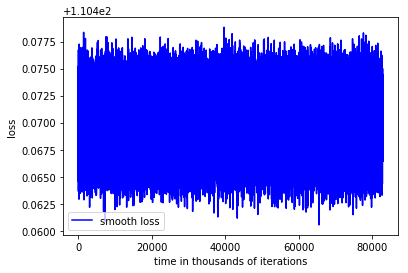

In [387]:
plt.plot(range(len(losses)), losses, 'b', label='smooth loss')
plt.xlabel('time in thousands of iterations')
plt.ylabel('loss')
plt.legend()
plt.show()
